# Overview

This notebook was made to document initial data exploration. The driving question to this project is  "Do they get at least 30 minutes of moderate activity on most days of the week?" We are analysing data from three individuals (three unique device IDs) from three datasets, with data being collected daily, per hour, and per minute.

In [2]:
# initialising and importing the CSVs

import pandas as pd
import matplotlib.pyplot as plt

daily_sc = pd.read_csv("C:\\Users\\kylie\\Downloads\\dailySteps_merged.csv")
hour_sc = pd.read_csv("C:\\Users\\kylie\\Downloads\\hourlySteps_merged.csv")
min_sc = pd.read_csv("C:\\Users\\kylie\\Downloads\\minuteStepsWide_merged.csv")

# Initial Assumptions

Simply by skimming through the datasets, I assume that these individuals wear their devices consistently. Many other IDs had lengthy periods of 0 step counts in their hourly counts, but these didn't. Due to this, I attributed the low counts to low acitivity instead.

Another assumption that I had was that different lifestyles will show different step count patterns. Although they didn't really have any noticeable inactive periods that can attribute low counts to not wearing the decives, they still had different total counts. 

***

# Data Exploration

## Daily Step Counts (Q1 + Q2)

           Id  num_days   avg_per_day  max_steps  min_steps most_active_day
0  1644430081        30   7282.966667      18213       1223      2016-04-30
1  2022484408        31  11370.645161      18387       3292      2016-04-30
2  4558609924        31   7685.129032      13743       3428      2016-04-21




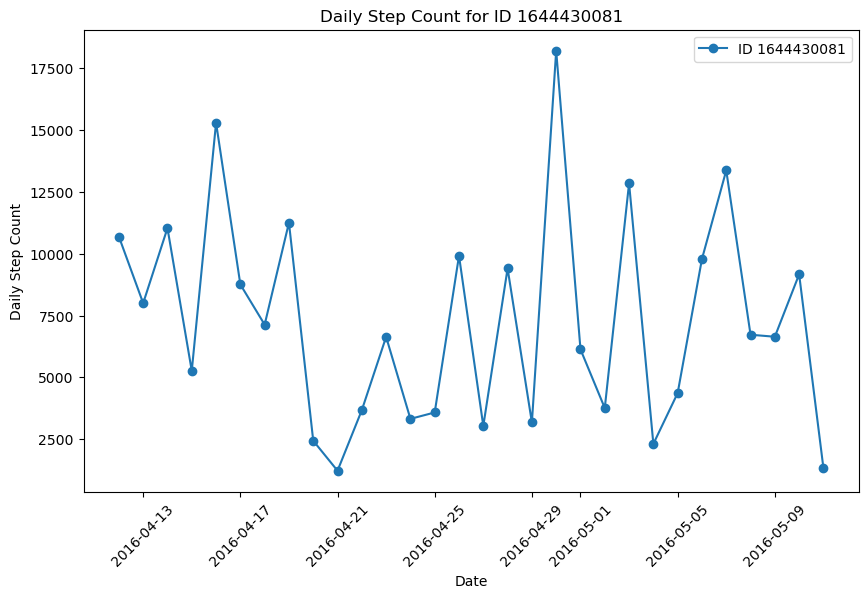

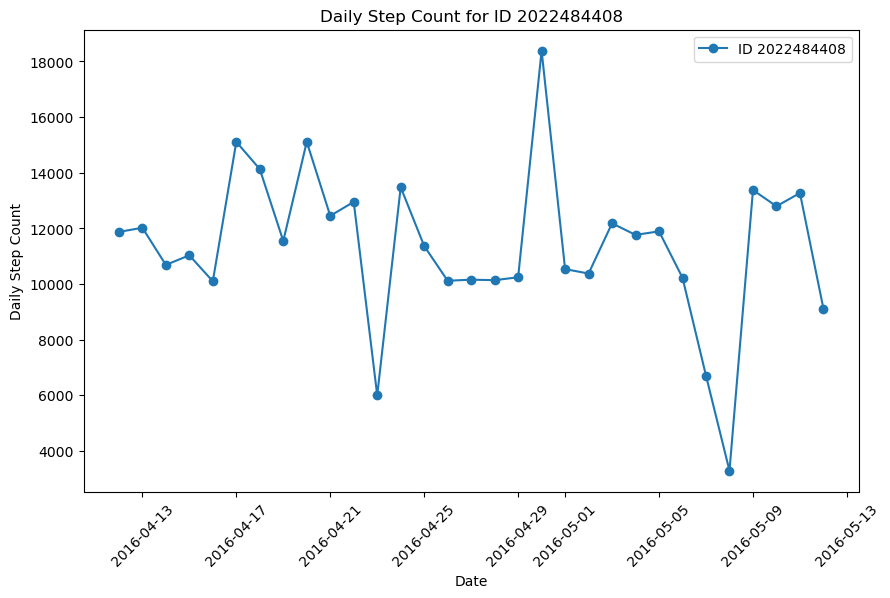

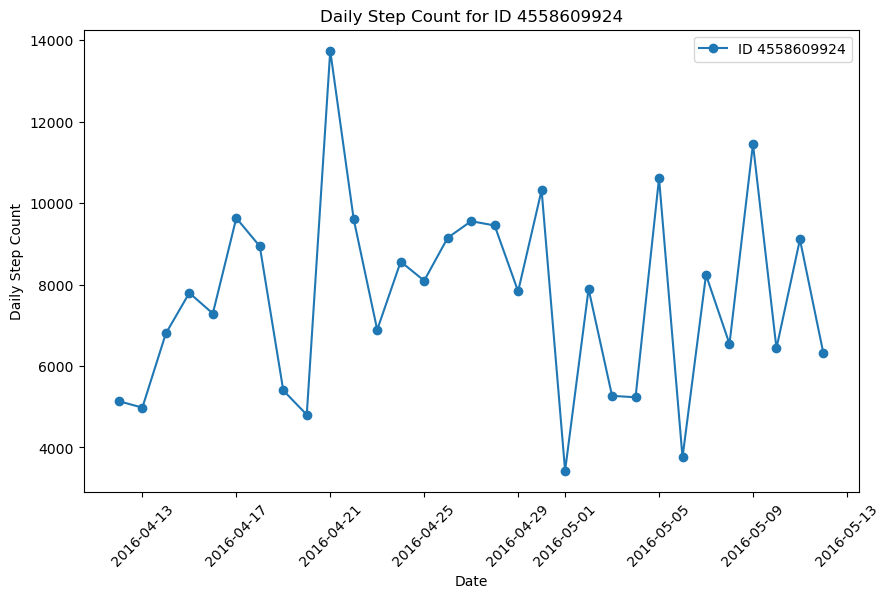

In [4]:
# cutting the data to shorten processes
indivs = [1644430081, 2022484408, 4558609924]
daily_sc = daily_sc[daily_sc['Id'].isin(indivs)]
hour_sc = hour_sc[hour_sc['Id'].isin(indivs)]
min_sc = min_sc[min_sc['Id'].isin(indivs)]

# Convert ActivityDay to datetime if it's not already
daily_sc['ActivityDay'] = pd.to_datetime(daily_sc['ActivityDay'])

# Calculate summary statistics
summary_stats = daily_sc.groupby('Id').agg(
    num_days=('ActivityDay', 'nunique'),
    avg_per_day=('StepTotal', 'mean'),
    max_steps=('StepTotal', 'max'),
    min_steps=('StepTotal', 'min')
).reset_index()

# Find the most active day for each ID
most_active_days = daily_sc.loc[daily_sc.groupby('Id')['StepTotal'].idxmax()]
most_active_days = most_active_days[['Id', 'ActivityDay']]
most_active_days.rename(columns={'ActivityDay': 'most_active_day'}, inplace=True)

# Merge the two summaries
summary_stats = summary_stats.merge(most_active_days, on='Id')

# Print the result
print(summary_stats)
print("\n")


# plot trends (matplotlib)
daily_sc['ActivityDay'] = pd.to_datetime(daily_sc['ActivityDay'])

for i in daily_sc['Id'].unique():
    id_data = daily_sc[daily_sc['Id'] == i]
    id_data = id_data.sort_values('ActivityDay')
    
    plt.figure(figsize=(10,6))
    plt.plot(id_data['ActivityDay'], id_data['StepTotal'], marker = 'o', label=f'ID {i}')

    plt.title(f'Daily Step Count for ID {i}')
    plt.xlabel('Date')
    plt.ylabel('Daily Step Count')
    plt.xticks(rotation=45)
    plt.legend()

There aren't really any noticeable trends on their step counts (e.g. more active either on weekdays or weekends). However, we can see the difference in their lifestyles. The second ID (2022484408) had a higher average, and it had a more noticeable baseline. This probably meant that this individual was more active, and made sure that they try to hit a certain minimum amount of steps everyday.

___

## Hourly Step Counts

In [6]:
print("HOURLY DATA")
# hourly data exploration for each individual
for i in hour_sc['Id'].unique():
    id_data = hour_sc[hour_sc['Id'] == i]
    description = id_data['StepTotal'].describe()
    
    print(f"ID: {i}")
    print(description)
    print("\n")



hour_sc['ActivityHour'] = pd.to_datetime(hour_sc['ActivityHour'])


HOURLY DATA
ID: 1644430081
count     708.000000
mean      307.806497
std       589.610641
min         0.000000
25%         0.000000
50%        22.500000
75%       354.750000
max      4660.000000
Name: StepTotal, dtype: float64


ID: 2022484408
count     736.000000
mean      477.869565
std       861.297289
min         0.000000
25%         0.000000
50%       101.500000
75%       624.750000
max      5596.000000
Name: StepTotal, dtype: float64


ID: 4558609924
count     736.000000
mean      323.245924
std       546.790099
min         0.000000
25%         0.000000
50%       148.500000
75%       433.000000
max      4688.000000
Name: StepTotal, dtype: float64




C:\Users\kylie\AppData\Local\Temp\ipykernel_29844\813007631.py:13: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  hour_sc['ActivityHour'] = pd.to_datetime(hour_sc['ActivityHour'])



Considering plotting for every hour can be too overwhelming to see any patterns, the plotting will only be done for the days that have low total step counts. This is done to see whether these low counts are due to inactivity/not wearing the device, or simply just a difference in lifestyle. For this, we will be filtering days that have lower totals than usual. Taking into account that all three IDs have different first quartiles, we will be taking the median of the three quartiles, because the second ID has a lower quartile of above 10,000, which would bring the mean up for the three IDs. The median is then rounded down to 5000 because the first ID still had a lot of days under the cut off.

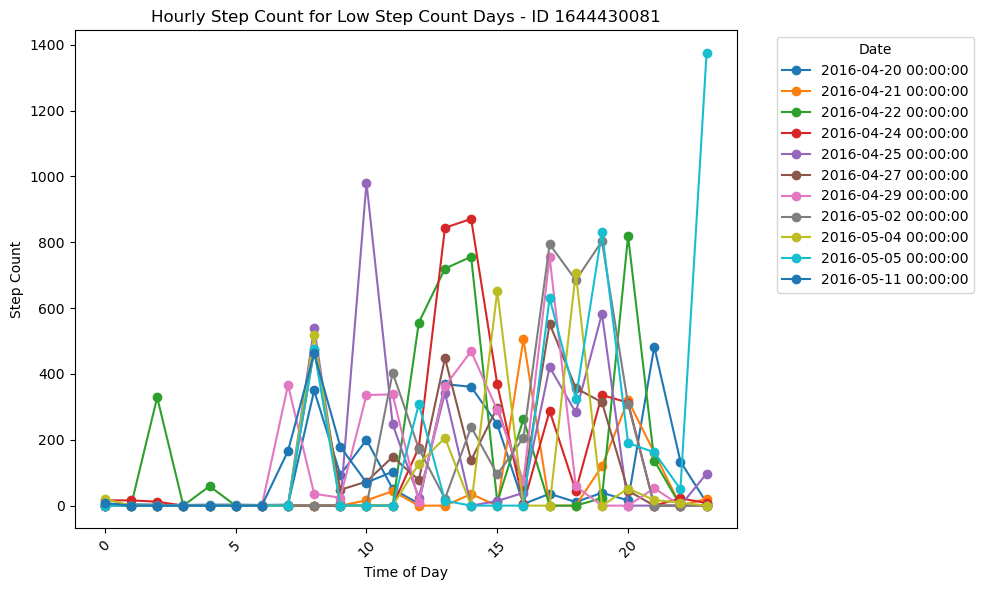

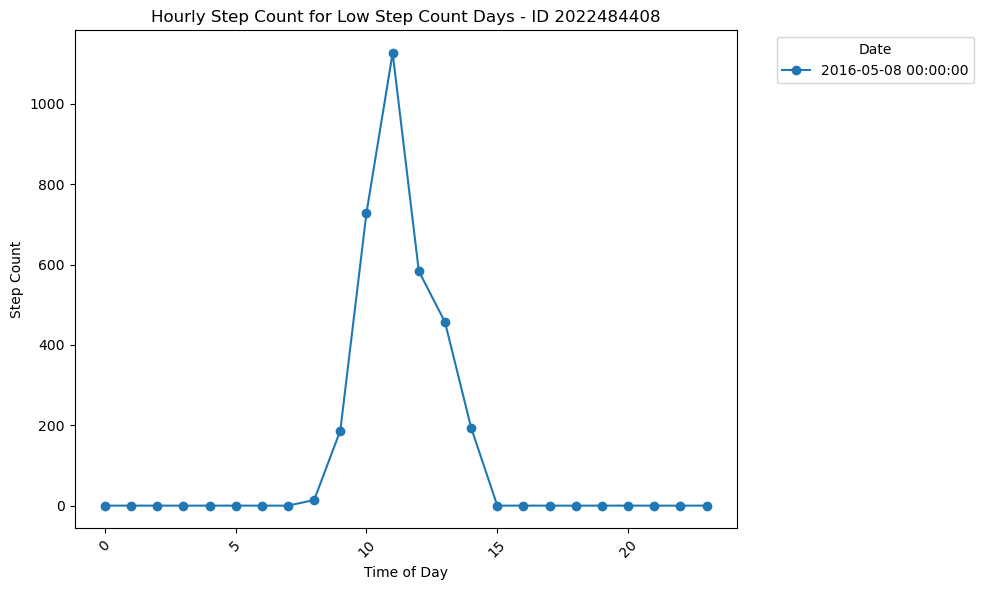

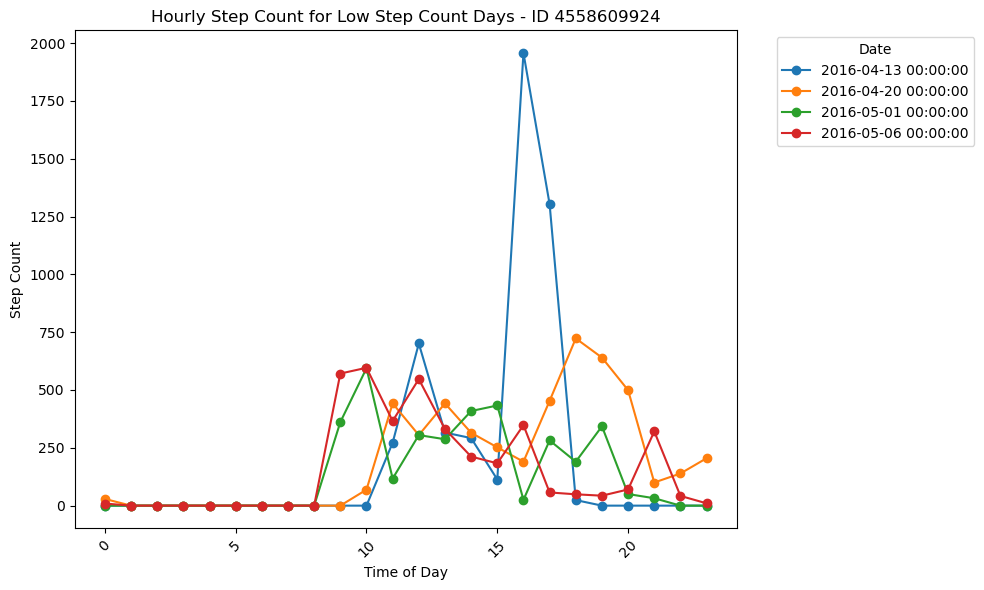

In [8]:
# taking the cut off
low_count = 5000

low_step_days = daily_sc[daily_sc['StepTotal'] < low_count]


# because there was a typeerror without this
def time_to_hours(t):
    return t.hour + t.minute / 60

# separating the dates and time in the hour_sc
hour_sc['ActivityDay'] = hour_sc['ActivityHour'].dt.date
hour_sc['ActivityTime'] = hour_sc['ActivityHour'].dt.time  # Get only the time (hours and minutes)


# a dictionary for the IDs that have low step days
low_step_days_dict = low_step_days.groupby('Id')['ActivityDay'].apply(list).to_dict()
# looping over the data to get the ones during low step days
for i in low_step_days_dict:  # each unique 'Id' (because I don't want too many graphs)
    id_data = hour_sc[hour_sc['Id'] == i]  

    plt.figure(figsize=(10, 6))  
    # a new graph per ID
    
    for date in low_step_days_dict[i]:
        daily_data = id_data[id_data['ActivityDay'] == pd.to_datetime(date).date()].copy()
       
        if not daily_data.empty:
            # convert 'ActivityTime' to hours to avoid typeerror
            daily_data.loc[:, 'ActivityHours'] = daily_data['ActivityTime'].apply(time_to_hours)
            plt.plot(daily_data['ActivityHours'], daily_data['StepTotal'], marker='o', label=f'{date}')
    
    # Plot settings
    plt.title(f'Hourly Step Count for Low Step Count Days - ID {i}')
    plt.xlabel('Time of Day')
    plt.ylabel('Step Count')
    plt.xticks(rotation=45)
    plt.legend(title='Date', bbox_to_anchor=(1.05, 1), loc='upper left')  # Place legend outside the plot
    plt.tight_layout()
    plt.show()


___

## Minute Step Counts (Q3)

In [10]:
# extracting the minutes (Steps00 to Steps59)
minute_columns = [f'Steps{i:02}' for i in range(60)]

# 1. counting non-zero minutes
min_sc['non_zero_minutes'] = min_sc[minute_columns].gt(0).sum(axis=1)

# 2. missing data (NaN)
min_sc['missing_data'] = min_sc[minute_columns].isna().sum(axis=1)

# 3. avg steps per minute
min_sc['avg_steps_per_minute'] = min_sc[minute_columns].mean(axis=1)

# 4. max & min steps per min
min_sc['max_steps'] = min_sc[minute_columns].max(axis=1)
min_sc['min_steps'] = min_sc[minute_columns].min(axis=1)

# 5. most active min (for extra observation)
min_sc['most_active_minute'] = min_sc[minute_columns].idxmax(axis=1)

# summary statistics
min_summary = min_sc.groupby('Id').agg(
    total_non_zero_min=('non_zero_minutes', 'sum'),
    missing_data=('missing_data', 'sum'),
    avg_per_min=('avg_steps_per_minute', 'mean'),
    max_steps=('max_steps', 'max'),
    min_steps=('min_steps', 'min'),
    most_active_min=('most_active_minute', lambda x: x.mode()[0])  # Most frequent active minute
).reset_index()

print(min_summary)

           Id  total_non_zero_min  missing_data  avg_per_min  max_steps  \
0  1644430081                5978             0     5.049537        134   
1  2022484408                9217             0     7.843507        176   
2  4558609924                9193             0     5.503231        207   

   min_steps most_active_min  
0          0         Steps00  
1          0         Steps00  
2          0         Steps00  



___

# Final Statements 

From this data exploration, I learnt that different lifestyles can create that big of a difference in step counts. Due to the first individual having a less active lifestyle than the others, many of their usual days are counted as days with low step counts. However, based on the anlaysis done, the inactivity were all explainable by simply low activity instead of not wearing the device (lack of lengthy periods of 0 step counts).

My driving problem was whether people are getting at least 30 minutes of moderate exercise. Based on this, I am now familiar on how to tackle this problem with these three datasets. Something to complete the analysis is answering what counts as moderate exercise. With that information, counting periods with totals that count as moderate exercise would help in answering the problem.